In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 1889  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 2358 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 5

In [ ]:
DEPRESSIVE_TWEETS_CSV = '/content/gdrive/MyDrive/MTech-project/data/depr.csv'
RANDOM_TWEETS_CSV = '/content/gdrive/MyDrive/MTech-project/data/non-depr.csv'
EMBEDDING_FILE = '/content/gdrive/MyDrive/MTech-project/embedding/GoogleNews-vectors-negative300.bin.gz'

In [ ]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV,  header = None, nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV,   nrows = RANDOM_NROWS)

In [ ]:
depressive_tweets_df.head()

,0,1
0,target,tweet
1,1,At least Ryleigh didn t win that world title.....
2,1,I m officially depressed
3,1,Reduce Your Anxiety Naturally. depressed
4,1,"If you know someone with fibromyalgia, please ..."


In [ ]:
depressive_tweets_df=depressive_tweets_df.iloc[1:,:]
depressive_tweets_df.head()

,0,1
1,1,At least Ryleigh didn t win that world title.....
2,1,I m officially depressed
3,1,Reduce Your Anxiety Naturally. depressed
4,1,"If you know someone with fibromyalgia, please ..."
5,1,Another day in the life of a depressed individ...


In [ ]:
depressive_tweets_df.reset_index(inplace = True, drop = True)
depressive_tweets_df.head()

,0,1
0,1,At least Ryleigh didn t win that world title.....
1,1,I m officially depressed
2,1,Reduce Your Anxiety Naturally. depressed
3,1,"If you know someone with fibromyalgia, please ..."
4,1,Another day in the life of a depressed individ...


In [ ]:
depressive_tweets_df.shape

(1888, 2)

In [ ]:
random_tweets_df.head()

,target,tweet
0,0,Today in Selfcare beauty amp laughs Kung Fu Pa...
1,0,If this is your response to someone saying the...
2,0,Apparently you get a free pass just by mention...
3,0,When you will never again give birth to violen...
4,0,Aw man im outta pizza rolls


In [ ]:
random_tweets_df.shape

(2357, 2)

In [ ]:
random_tweets_df.tail()

,target,tweet
2352,0,honestly just wanna watch OTH have no Netflix ...
2353,0,"May the new year abound in H s Health, Hope, H..."
2354,0,Compact Metal Leaf Grinder with Four Layers pi...
2355,0,First Christmas in YEARS that I have to work. ...
2356,0,It s okay sus. Let that hurt go that s me hugg...


In [ ]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            #tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
depressive_tweets_arr = [x for x in depressive_tweets_df[1]]
random_tweets_arr = [x for x in random_tweets_df['tweet']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 10651 unique tokens


In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (1888, 140)
Shape of data_r tensor: (2346, 140)


In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [ ]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [ ]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 300)          3195300   
                                                                 
 conv1d (Conv1D)             (None, 140, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 70, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 300)               399600    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                        

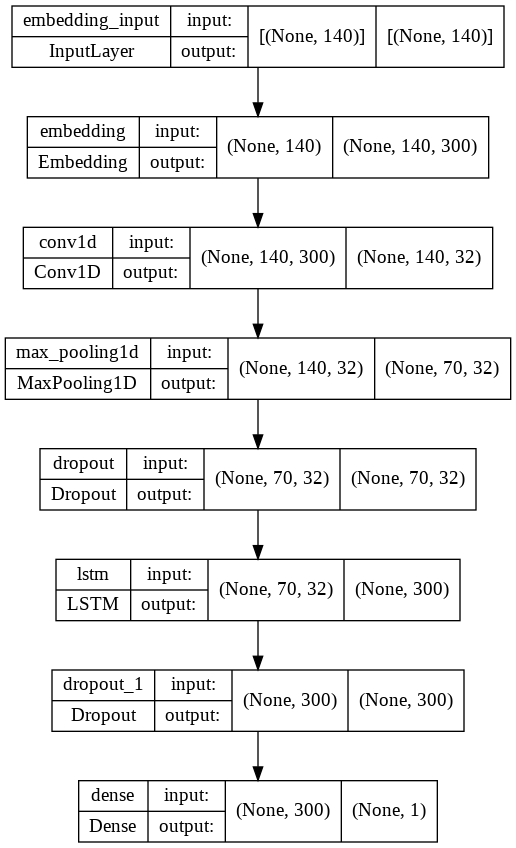

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/5
64/64 [==============================] - 15s 21ms/step - loss: 0.4278 - acc: 0.8031 - val_loss: 0.2475 - val_acc: 0.9116
Epoch 2/5
64/64 [==============================] - 1s 11ms/step - loss: 0.1959 - acc: 0.9256 - val_loss: 0.1835 - val_acc: 0.9375
Epoch 3/5
64/64 [==============================] - 1s 11ms/step - loss: 0.1373 - acc: 0.9531 - val_loss: 0.1652 - val_acc: 0.9481
Epoch 4/5
64/64 [==============================] - 1s 11ms/step - loss: 0.1052 - acc: 0.9661 - val_loss: 0.1715 - val_acc: 0.9469
Epoch 5/5
64/64 [==============================] - 1s 10ms/step - loss: 0.0787 - acc: 0.9764 - val_loss: 0.1862 - val_acc: 0.9469


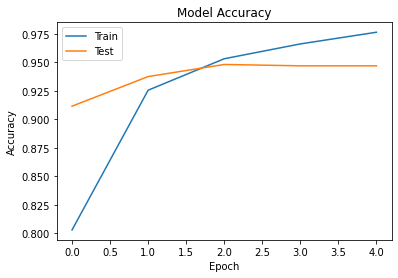

In [ ]:
plt.plot(hist.history['acc'], label='Train')
plt.plot(hist.history['val_acc'],  label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

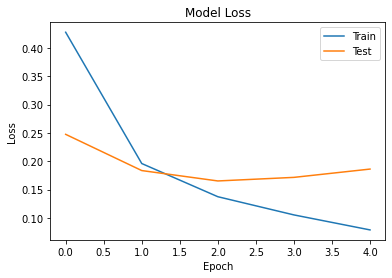

In [ ]:
plt.plot(hist.history['loss'],label='Train')
plt.plot(hist.history['val_loss'],label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 95.28%


In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       469
           1       0.96      0.93      0.95       378

    accuracy                           0.95       847
   macro avg       0.95      0.95      0.95       847
weighted avg       0.95      0.95      0.95       847



In [ ]:
#@title Default title text
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(labels_test, labels_pred)
cm 

In [ ]:
#@title Default title text
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d',cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Saving the model

In [ ]:
import pickle

# saving
with open('/content/gdrive/MyDrive/MTech-project/cnn-lstm/new/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
# loading
with open('/content/gdrive/MyDrive/MTech-project/cnn-lstm/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
"""

"\n# loading\nwith open('/content/gdrive/MyDrive/MTech-project/cnn-lstm/tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n"

In [ ]:
import h5py


model.save('/content/gdrive/MyDrive/MTech-project/cnn-lstm/new/detector_model_finalX.pt')
model.save('/content/gdrive/MyDrive/MTech-project/cnn-lstm/new/detector_model_finalX.h5')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/cnn-lstm/new/detector_model_finalX.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/cnn-lstm/new/detector_model_finalX.pt/assets


In [ ]:
#Run the code below to save model to json and serialize the weights to HDF5

model_json = model.to_json()
with open("/content/gdrive/MyDrive/MTech-project/cnn-lstm/new/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/MTech-project/cnn-lstm/new/model_weights.h5")
print("Saved model")


Saved model


In [ ]:
model.save('/content/gdrive/MyDrive/MTech-project/cnn-lstm/new/classifier.model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/cnn-lstm/new/classifier.model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/cnn-lstm/new/classifier.model/assets


# Testing

In [ ]:
import pickle
# loading
with open('/content/gdrive/MyDrive/MTech-project/cnn-lstm/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('/content/gdrive/MyDrive/MTech-project/cnn-lstm/detector_model_finalX.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 300)          3195300   
                                                                 
 conv1d_2 (Conv1D)           (None, 140, 32)           28832     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 70, 32)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                      

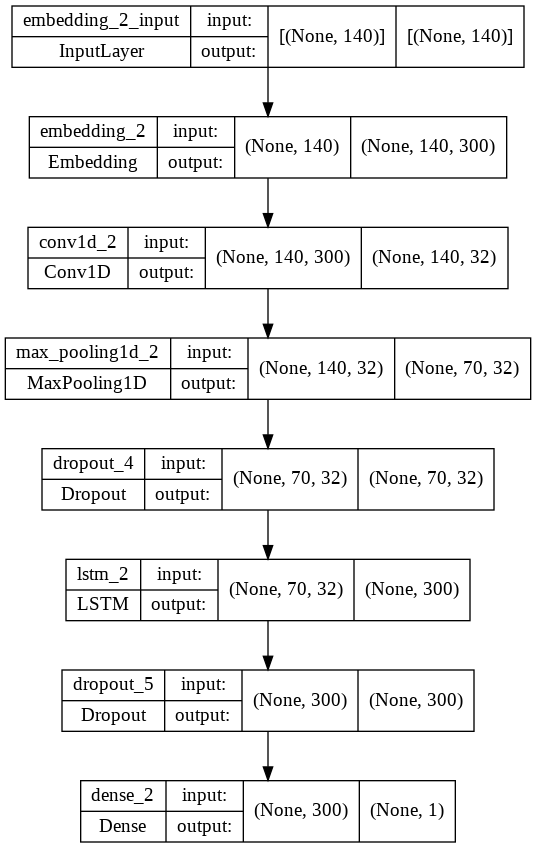

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
#MAX_NB_WORDS = 20000

In [ ]:
def label(text):
  if(text>0.5):
    print("Depressive")
  else:
    print("Non-Depressive")

In [ ]:
test=["my life is happy"]
sequences_d = tokenizer.texts_to_sequences(test)
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
test_predict = model.predict(data_d)
label(test_predict)

Non-Depressive


In [ ]:
test=["my life is boring and lonely"]
sequences_d = tokenizer.texts_to_sequences(test)
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
test_predict = model.predict(data_d)
label(test_predict)

Depressive


In [ ]:
def label1(text):
  text=text.flatten()
  for i in range(0,len(text)):
    if(text[i]>0.5):
      print("Depressive")
    else:
      print("Non-Depressive")

In [ ]:
test=['Extreme sadness, lack of energy, hopelessness',
                  'Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits',
                  'feeling lonely and leading a boring life',
      ' happy and best']
sequences_d = tokenizer.texts_to_sequences(test)
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
test_predict = model.predict(data_d)
label1(test_predict)

Depressive
Non-Depressive
Depressive
Non-Depressive


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/MTech-project/cnn-lstm/classifier.model')
